In [121]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [122]:
import pandas as pd
import numpy as np
import scipy.stats as sp_stats
import requests
from datetime import timedelta
import matplotlib.pyplot as plt

In [171]:
class CusumTest:
    """ Chu-Stinchcombe-White CUSUM Test on Levels
    Implements a hypothesis test where the null-hypothesis is that the
    timeseries does not change.  For each bar we compute the test statistic
    (and 95% threshold) for multiple backward windows up to ticks_required
    away.  We take the max over all these stats to compute our filter value.
    Ref: de Prado Section 17.3.2
    """
    def __init__(self, ticks_required, **kwargs):
        self.ticks_required = ticks_required
        # out name should uniquely identify the feature with all its args
        self.output_column_names = []
        for ticks in ticks_required:
            self.output_column_names.append('{0}_cusum_test'.format(ticks))
            
        self.critical_value = 0

        def compute_stat(x, n_tick, thresholds):
            """
            Computes the max S_n_t for all n inside the window.
            """
            var = np.square(np.diff(x)).mean()
            if np.isnan(var) or var < 1e-7:
                return 0.0

            x_slice = x[-2::-1]
            result = (x[-1] - x_slice) / np.sqrt(var * n_tick)
            result -= thresholds
            result = result.max()

            return float(result > 0)
        
        def compute_stat_log_volume(x, max_ticks, log_volume, index):
            """
            Computes the max S_n_t for all n inside the window.
            """
            
            var = np.square(np.diff(x)).mean()
            if np.isnan(var) or var < 1e-7:
                return 0.0

            x_slice = x[-2::-1]
            result = (x[-1] - x_slice) / np.sqrt(var * n_tick)
            result -= thresholds
            result = result.max()

            return float(result > 0)

        self.compute_stat = compute_stat
        self.compute_stat_log_volume = compute_stat_log_volume


    def generate_bulk(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        cusum_test_stats = []
        for ticks in self.ticks_required:
            rolling = log_prices.rolling(
                ticks, min_periods=ticks)
            n_tick = range(1, ticks)
            thresholds = np.sqrt(4.6 + np.log(n_tick))
            cusum_test_stat = (rolling.apply(lambda x: self.compute_stat(x, n_tick, thresholds), raw=True).values).astype(np.float)
            cusum_test_stats.append(cusum_test_stat)

        cusum_test_stats = np.array(cusum_test_stats)
        return pd.DataFrame(index=reg_ticks.index,
                            data=cusum_test_stats.transpose(),
                            columns=self.output_column_names)
    
    def generate_bulk_log_volume(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        log_volume = np.log(reg_ticks['volume']).tolist()
        cusum_test_stats = []
        for max_ticks in self.ticks_required:
            cusum_test_stat = []
            for i in range(0,len(log_volume)):
                ticks = int(max_ticks / log_volume[i])
                n_tick = range(1, ticks)
                thresholds = np.sqrt(4.6 + np.log(n_tick))
                rolling = log_prices.rolling(ticks, min_periods=ticks)
                stats = (rolling.apply(lambda x: self.compute_stat(x, n_tick, thresholds), raw=True).values).astype(np.float)                
                cusum_test_stat.append(stats[i])
            cusum_test_stats.append(cusum_test_stat)

        cusum_test_stats = np.array(cusum_test_stats)
        return pd.DataFrame(index=reg_ticks.index,
                            data=cusum_test_stats.transpose(),
                            columns=self.output_column_names)


In [141]:
class StructuralBreakFeatures:
    DEFAULT_FEATURES_TO_CALCULATE = []
    DROP_COLUMNS = ['open', 'high', 'low']

    def __init__(self,
                 features_to_calculate=None,
                 interval_size: timedelta=timedelta(days=1),
                 drop_columns=None):
        if features_to_calculate is None:
            features_to_calculate = self.DEFAULT_FEATURES_TO_CALCULATE

        if drop_columns is None:
            drop_columns = self.DROP_COLUMNS

        # Create feature generator and compute features
        self.interval_type = 'time'
        self.interval_size = interval_size
        self.features_to_calculate = features_to_calculate
        self.drop_columns = drop_columns

    def get_feature_data(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = CusumTest(self.features_to_calculate)
        data_df_enriched = data_df.join(feature_generator.generate_bulk(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

    def get_feature_data_log_volume(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = CusumTest(self.features_to_calculate)
        data_df_enriched = data_df.join(feature_generator.generate_bulk_log_volume(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

In [125]:

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [126]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=900)

In [127]:
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,1143.999999,1483601400,1145.000000,1135.000000,1137.020000,9.170638,10475.203351,1142.254643
1,1146.628895,1483602300,1146.628895,1141.242295,1143.999998,21.620561,24698.210829,1142.348302
2,1146.628879,1483603200,1148.561412,1142.000000,1146.628895,21.086122,24164.714141,1146.000865
3,1124.500000,1483604100,1148.799997,1120.000000,1142.000000,98.798854,111593.901661,1129.506029
4,1136.000000,1483605000,1136.000000,1124.018000,1124.500000,23.515077,26504.327610,1127.120601


In [128]:
df['time'] = pd.to_datetime(df['date'], unit='s')
df.index = df['time']
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2017-01-05 07:30:00,1143.999999,1483601400,1145.000000,1135.000000,1137.020000,9.170638,10475.203351,1142.254643,2017-01-05 07:30:00
2017-01-05 07:45:00,1146.628895,1483602300,1146.628895,1141.242295,1143.999998,21.620561,24698.210829,1142.348302,2017-01-05 07:45:00
2017-01-05 08:00:00,1146.628879,1483603200,1148.561412,1142.000000,1146.628895,21.086122,24164.714141,1146.000865,2017-01-05 08:00:00
2017-01-05 08:15:00,1124.500000,1483604100,1148.799997,1120.000000,1142.000000,98.798854,111593.901661,1129.506029,2017-01-05 08:15:00
2017-01-05 08:30:00,1136.000000,1483605000,1136.000000,1124.018000,1124.500000,23.515077,26504.327610,1127.120601,2017-01-05 08:30:00


In [129]:
df_prices = df[['close', 'high', 'low', 'open', 'weightedAverage']]
df_volume = (df[['quoteVolume', 'volume']] + 0.001)
log_df = np.log(pd.concat([df_prices, df_volume], axis=1))
log_df.head()

,close,high,low,open,weightedAverage,quoteVolume,volume
time,,,,,,,
2017-01-05 07:30:00,7.042286,7.043160,7.034388,7.036166,7.040759,2.216116,9.256766
2017-01-05 07:45:00,7.044582,7.044582,7.039873,7.042286,7.040841,3.073691,10.114486
2017-01-05 08:00:00,7.044582,7.046265,7.040536,7.044582,7.044034,3.048663,10.092649
2017-01-05 08:15:00,7.025094,7.046473,7.021084,7.040536,7.029536,4.593096,11.622622
2017-01-05 08:30:00,7.035269,7.035269,7.024665,7.025094,7.027422,3.157684,10.185063


In [130]:
df_daily = df.resample('D').mean()
df_log_daily = log_df.resample('D').mean()
# re-add time column - needed for feature generation
df_daily['time'] = pd.to_datetime(df_daily.index)
df_log_daily['time'] = pd.to_datetime(df_log_daily.index)

In [131]:
df_daily.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2017-01-05,1010.834362,1483630650,1021.641209,1000.414899,1012.924473,132.515630,131702.874248,1010.582202,2017-01-05
2017-01-06,930.675205,1483703550,937.530720,924.717101,931.727426,64.843948,59570.184821,930.678610,2017-01-06
2017-01-07,873.801842,1483789950,878.540089,868.573548,873.781573,53.480216,46313.313022,873.627905,2017-01-07
2017-01-08,918.490203,1483876350,921.183347,915.074203,918.400845,30.779592,28253.599772,918.142616,2017-01-08
2017-01-09,896.997354,1483962750,899.625412,894.980559,897.384379,18.160675,16263.817898,897.273159,2017-01-09


In [132]:
df_log_daily.head()

,close,high,low,open,weightedAverage,quoteVolume,volume,time
time,,,,,,,,
2017-01-05,6.916564,6.927237,6.906120,6.918543,6.916346,4.276778,11.193097,2017-01-05
2017-01-06,6.834912,6.842269,6.828495,6.836030,6.834931,3.744711,10.579602,2017-01-06
2017-01-07,6.772373,6.777840,6.766345,6.772361,6.772190,3.457830,10.229937,2017-01-07
2017-01-08,6.822651,6.825587,6.818924,6.822554,6.822275,2.935127,9.757312,2017-01-08
2017-01-09,6.799022,6.801952,6.796769,6.799453,6.799330,2.280986,9.080111,2017-01-09


In [142]:
features = [10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
cusum_features = StructuralBreakFeatures(
    features_to_calculate=features
)
enriched_cusum = cusum_features.get_feature_data(df_daily)
enriched_cusum.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,10_cusum_test,...,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
time,,,,,,,,,,,,,,,,,,,,,
2018-09-30,6603.167741,1538308350,6610.303793,6596.211640,6603.657911,4.717795,31176.687634,6602.742007,2018-09-30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-10-01,6608.840069,1538394750,6616.795235,6601.622670,6609.778557,4.721831,31129.210102,6609.244704,2018-10-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-10-02,6581.534314,1538481150,6586.866326,6575.809834,6582.587763,6.186685,40542.461221,6581.587104,2018-10-02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-10-03,6490.396787,1538567550,6497.566608,6482.847658,6490.707756,6.134086,39796.406631,6490.386636,2018-10-03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-10-04,6591.776770,1538646300,6598.458054,6586.514553,6590.678277,8.351074,55071.547613,6592.505634,2018-10-04,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [143]:
enriched_cusum.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,10_cusum_test,20_cusum_test,...,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
count,638.000000,6.380000e+02,638.000000,638.000000,638.000000,638.000000,6.380000e+02,638.000000,629.000000,619.000000,...,439.000000,389.000000,339.000000,289.000000,239.000000,189.000000,139.0,39.0,0.0,0.0
mean,5845.865442,1.511136e+09,5868.229409,5822.302206,5846.232608,68.980708,3.445483e+05,5845.373628,0.052464,0.109855,...,0.227790,0.262211,0.241888,0.159170,0.037657,0.005291,0.0,0.0,NaN,NaN
std,3905.673097,1.592511e+07,3927.268477,3882.712766,3906.091614,74.235542,4.351934e+05,3905.150701,0.223139,0.312961,...,0.419885,0.440403,0.428860,0.366469,0.190765,0.072739,0.0,0.0,NaN,NaN
min,785.475705,1.483631e+09,788.835227,781.691032,785.033909,3.403235,3.411802e+03,785.043530,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN
25%,2374.635733,1.497376e+09,2381.863755,2366.890401,2374.241240,14.875788,7.120455e+04,2374.568662,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN
50%,6301.429560,1.511136e+09,6320.147766,6290.377652,6301.327225,47.626977,1.989645e+05,6300.587179,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN
75%,8120.871343,1.524895e+09,8142.324432,8103.188202,8120.266320,93.193511,4.345797e+05,8120.611947,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN
max,19271.928990,1.538646e+09,19347.277980,19182.610597,19277.626231,509.339758,4.125401e+06,19265.948240,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,NaN,NaN


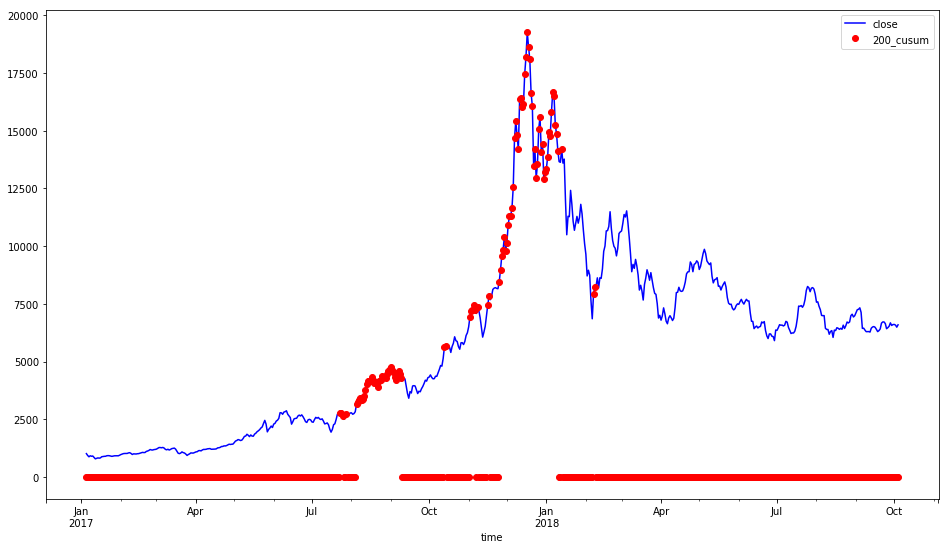

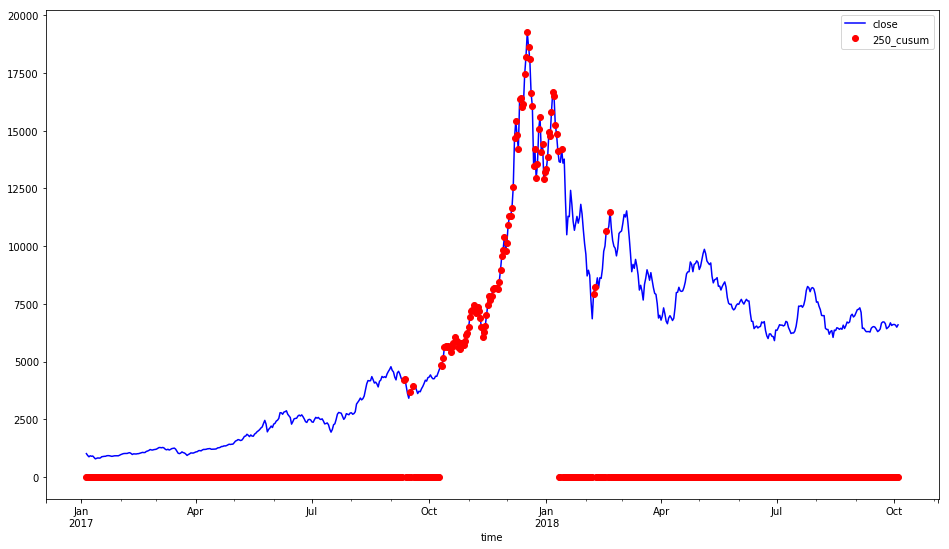

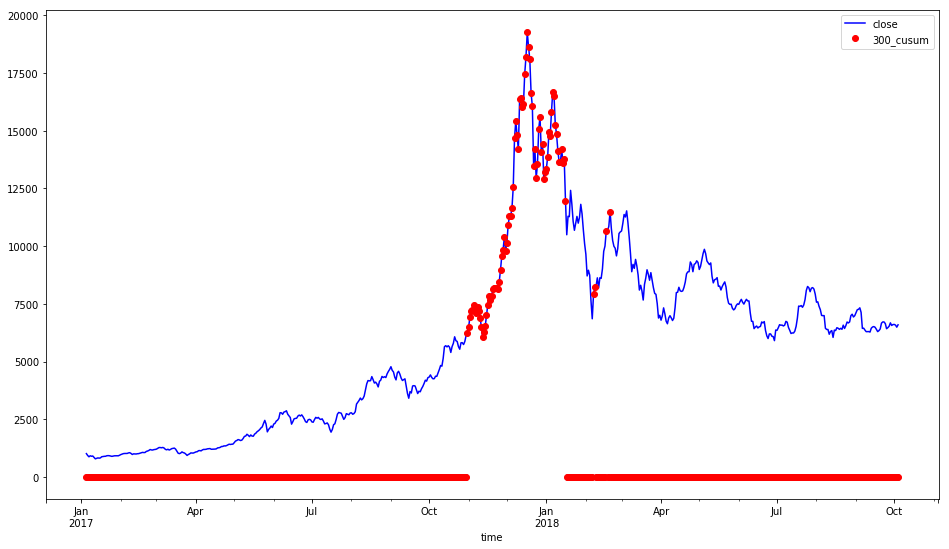

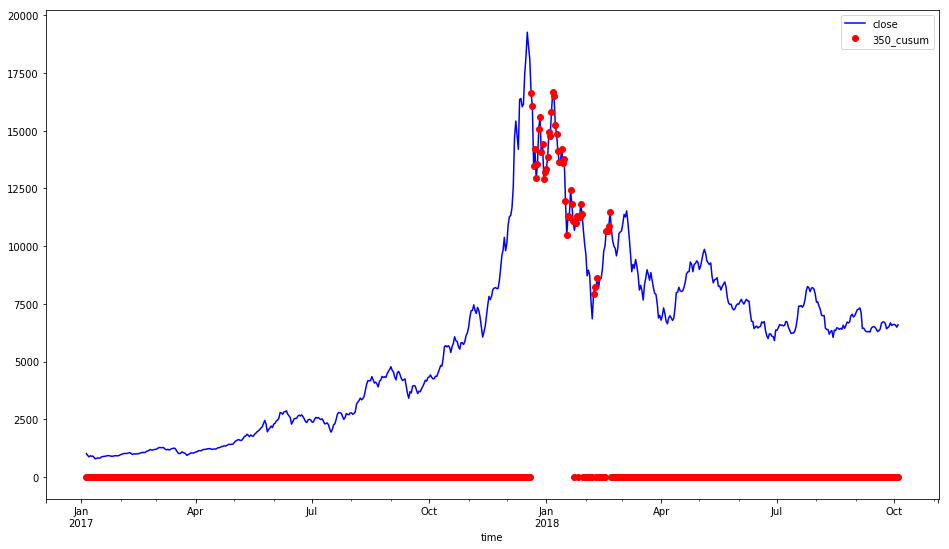

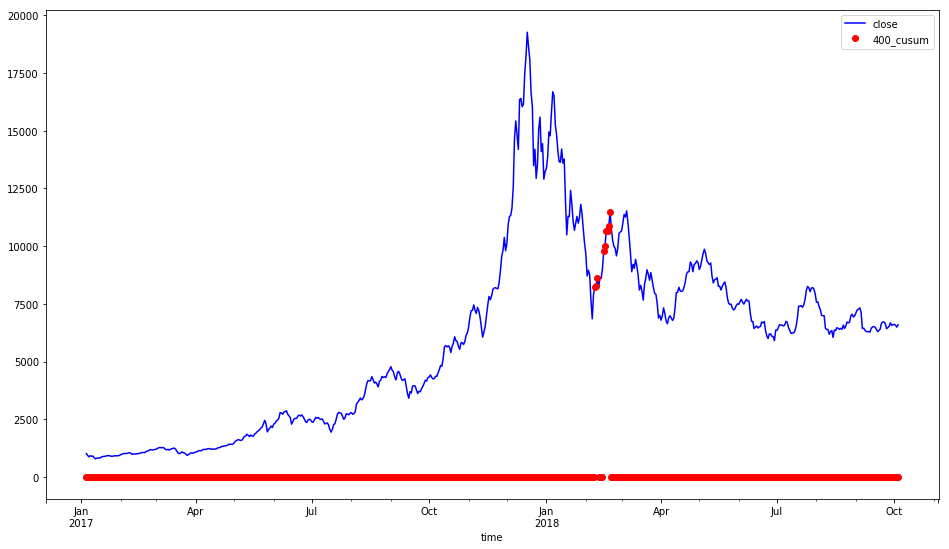

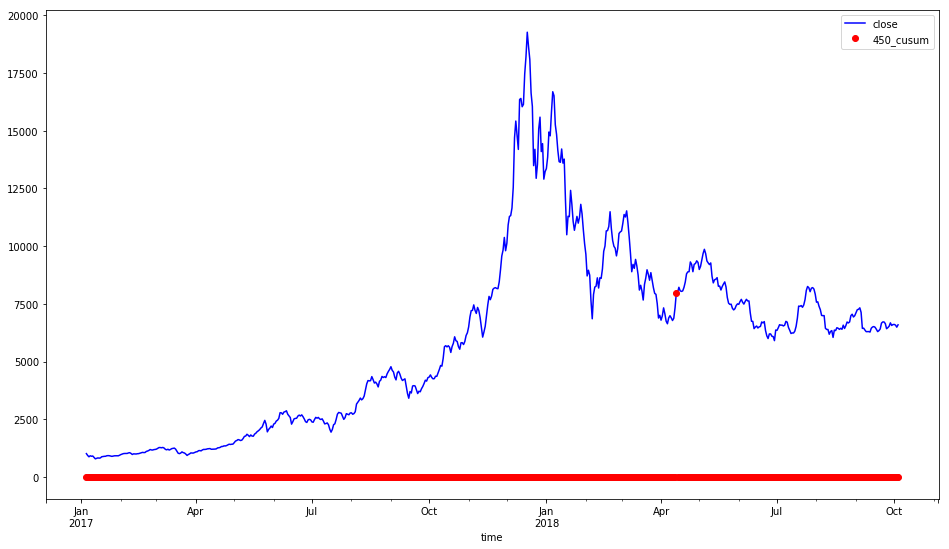

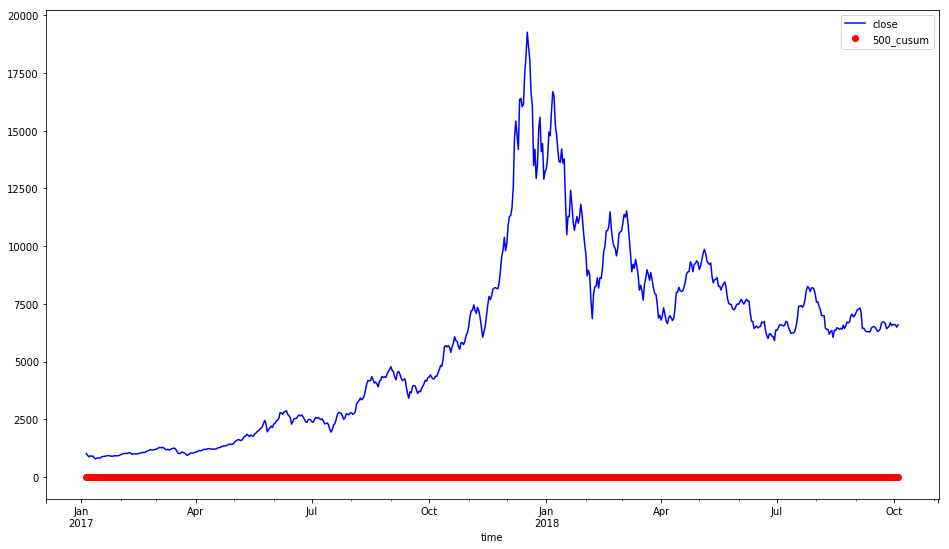

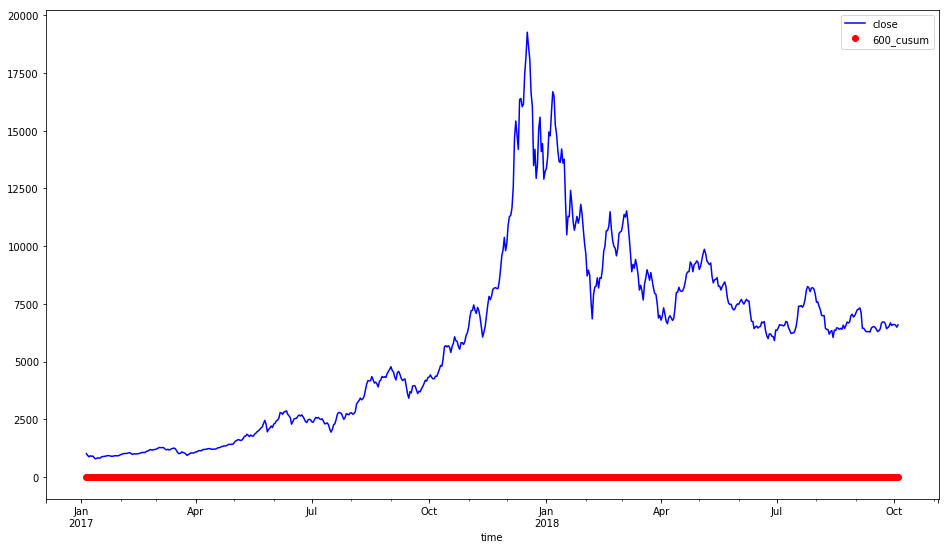

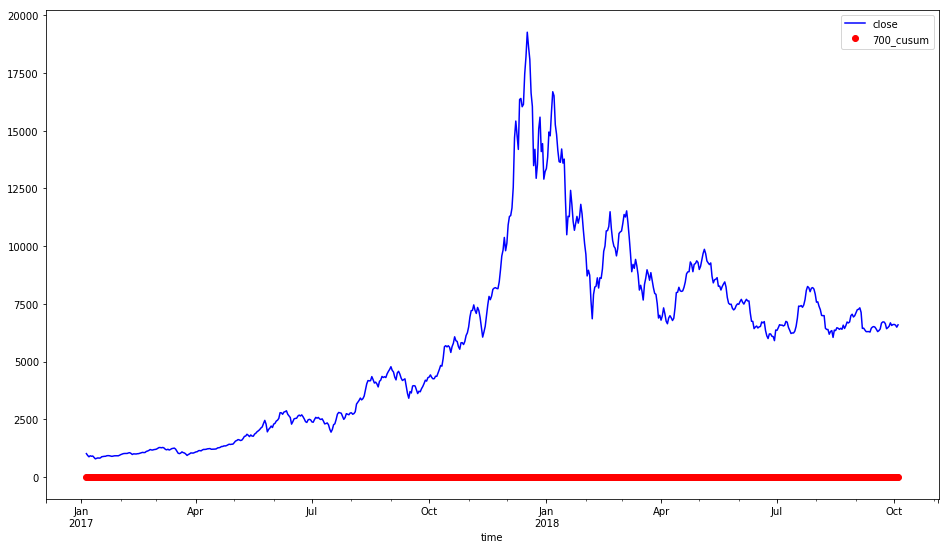

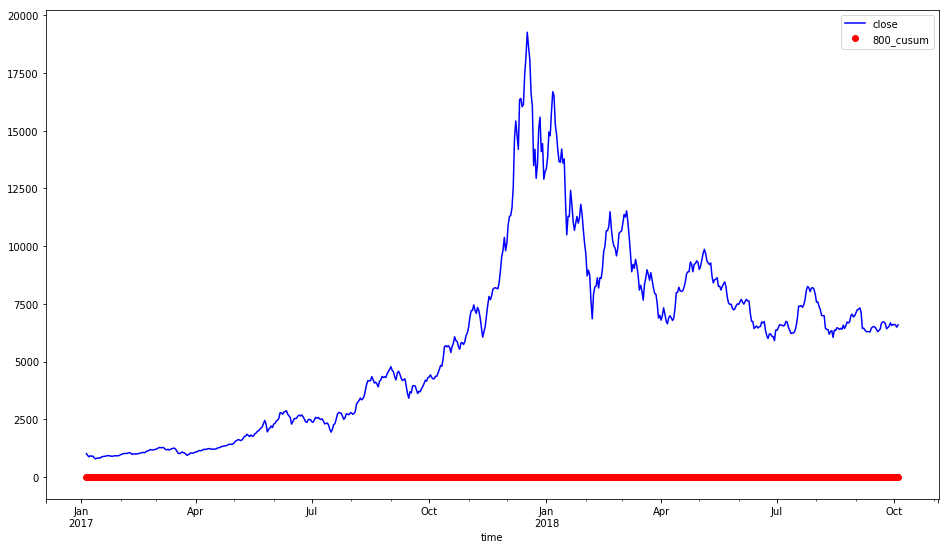

In [155]:
for feature in features:
    fig, ax = plt.subplots(figsize=(16,9))
    cusum = '{0}_cusum'.format(feature)
    cusum_test = '{0}_cusum_test'.format(feature)
    enriched_cusum['close'].plot(ax=ax, style='b-', legend=True)
    enriched_cusum[cusum] = enriched_cusum['close'].where(enriched_cusum[cusum_test] == 1.0, other=0.0)
    enriched_cusum[cusum].plot(ax=ax, style='ro', secondary_y=False, legend=True)

In [172]:
features = [200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
cusum_features = StructuralBreakFeatures(
    features_to_calculate=features
)
enriched_cusum = cusum_features.get_feature_data_log_volume(df_daily)
enriched_cusum.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
time,,,,,,,,,,,,,,,,,,,
2018-09-30,6603.167741,1538308350,6610.303793,6596.211640,6603.657911,4.717795,31176.687634,6602.742007,2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01,6608.840069,1538394750,6616.795235,6601.622670,6609.778557,4.721831,31129.210102,6609.244704,2018-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-02,6581.534314,1538481150,6586.866326,6575.809834,6582.587763,6.186685,40542.461221,6581.587104,2018-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-03,6490.396787,1538567550,6497.566608,6482.847658,6490.707756,6.134086,39796.406631,6490.386636,2018-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-04,6591.776770,1538646300,6598.458054,6586.514553,6590.678277,8.351074,55071.547613,6592.505634,2018-10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
enriched_cusum.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,200_cusum_test,250_cusum_test,300_cusum_test,350_cusum_test,400_cusum_test,450_cusum_test,500_cusum_test,600_cusum_test,700_cusum_test,800_cusum_test
count,638.000000,6.380000e+02,638.000000,638.000000,638.000000,638.000000,6.380000e+02,638.000000,619.000000,612.000000,609.000000,604.000000,597.000000,592.000000,590.000000,582.000000,576.000000,569.000000
mean,5845.865442,1.511136e+09,5868.229409,5822.302206,5846.232608,68.980708,3.445483e+05,5845.373628,0.079160,0.091503,0.123153,0.120861,0.134003,0.143581,0.150847,0.147766,0.171875,0.188049
std,3905.673097,1.592511e+07,3927.268477,3882.712766,3906.091614,74.235542,4.351934e+05,3905.150701,0.270207,0.288559,0.328883,0.326236,0.340942,0.350961,0.358204,0.355173,0.377600,0.391095
min,785.475705,1.483631e+09,788.835227,781.691032,785.033909,3.403235,3.411802e+03,785.043530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2374.635733,1.497376e+09,2381.863755,2366.890401,2374.241240,14.875788,7.120455e+04,2374.568662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6301.429560,1.511136e+09,6320.147766,6290.377652,6301.327225,47.626977,1.989645e+05,6300.587179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8120.871343,1.524895e+09,8142.324432,8103.188202,8120.266320,93.193511,4.345797e+05,8120.611947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19271.928990,1.538646e+09,19347.277980,19182.610597,19277.626231,509.339758,4.125401e+06,19265.948240,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


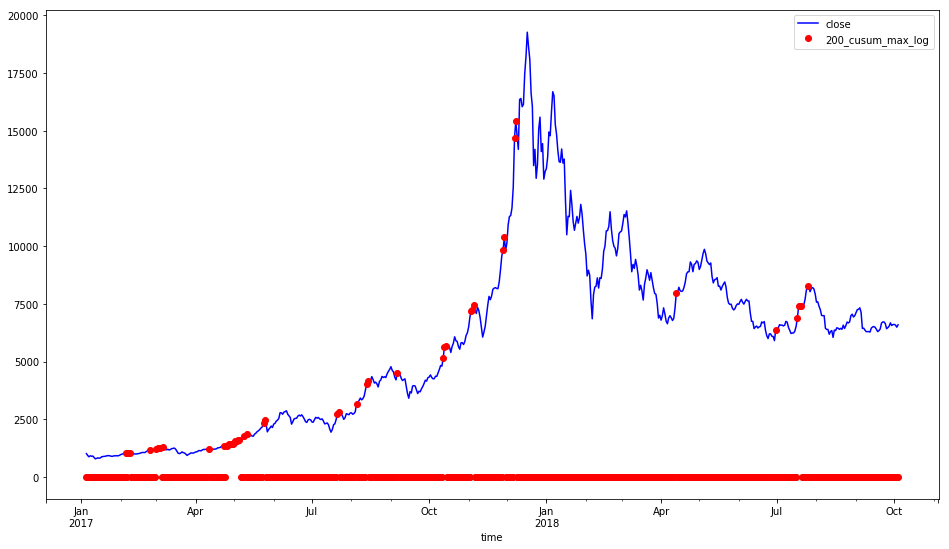

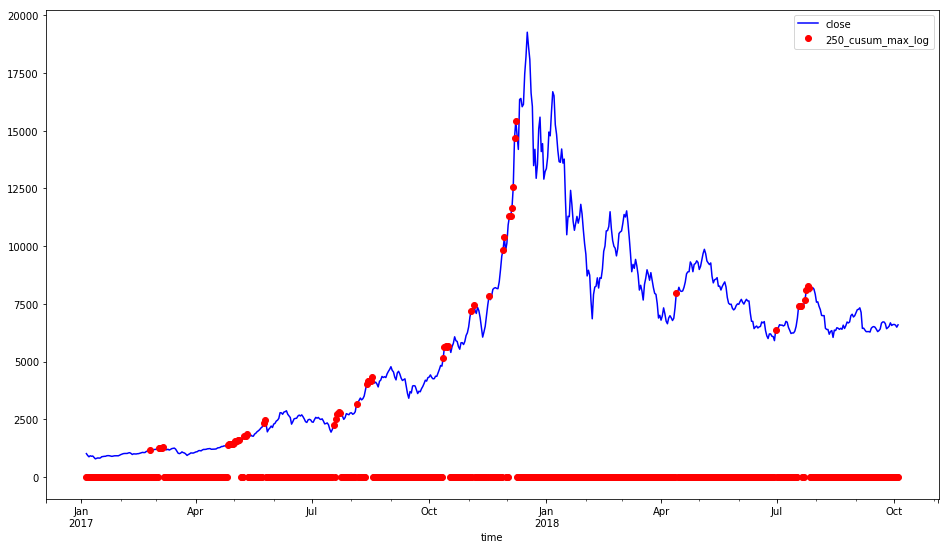

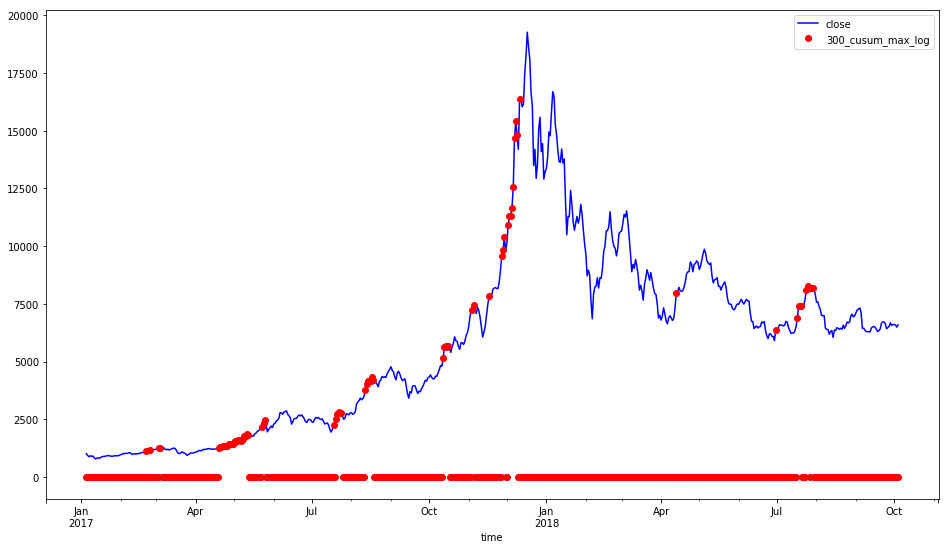

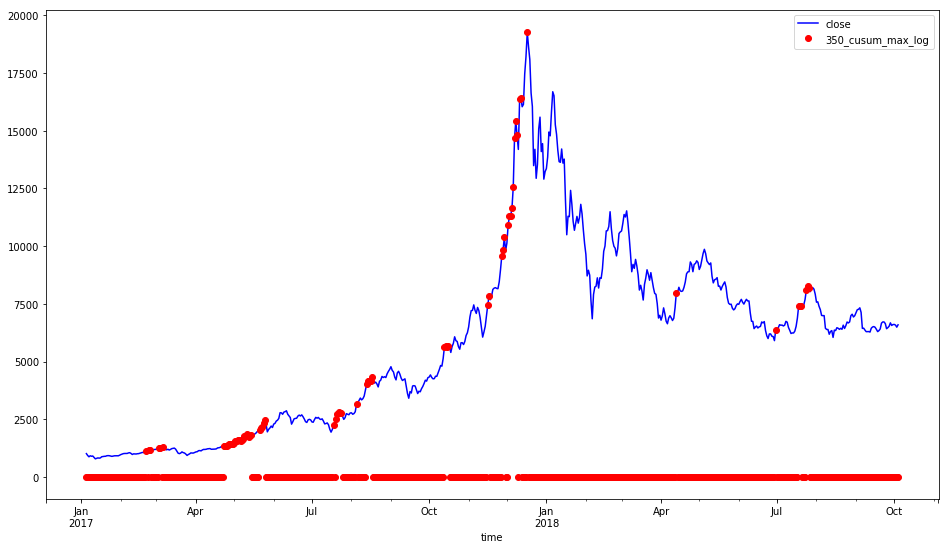

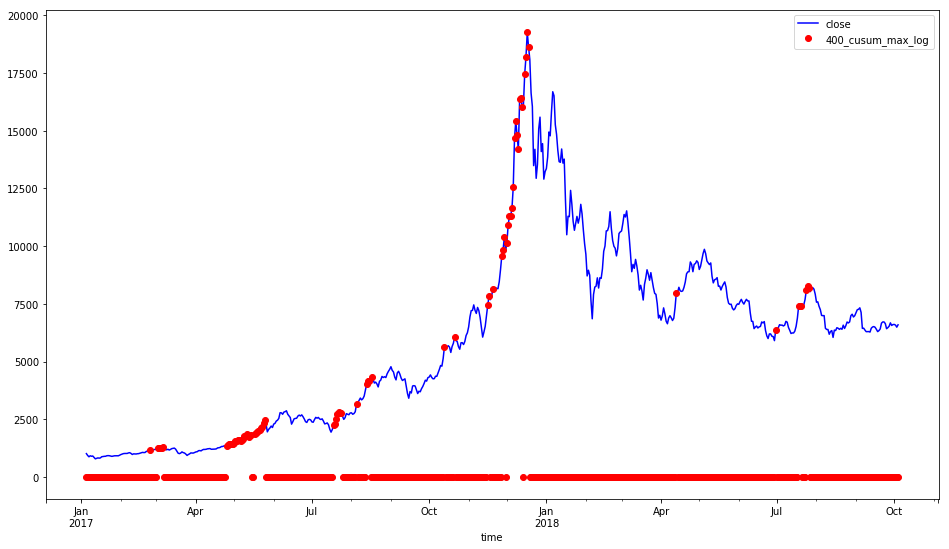

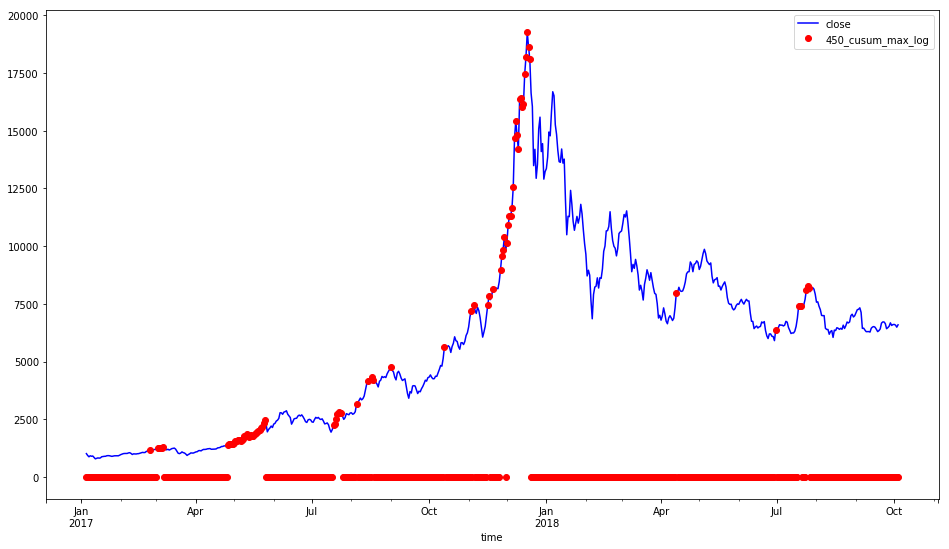

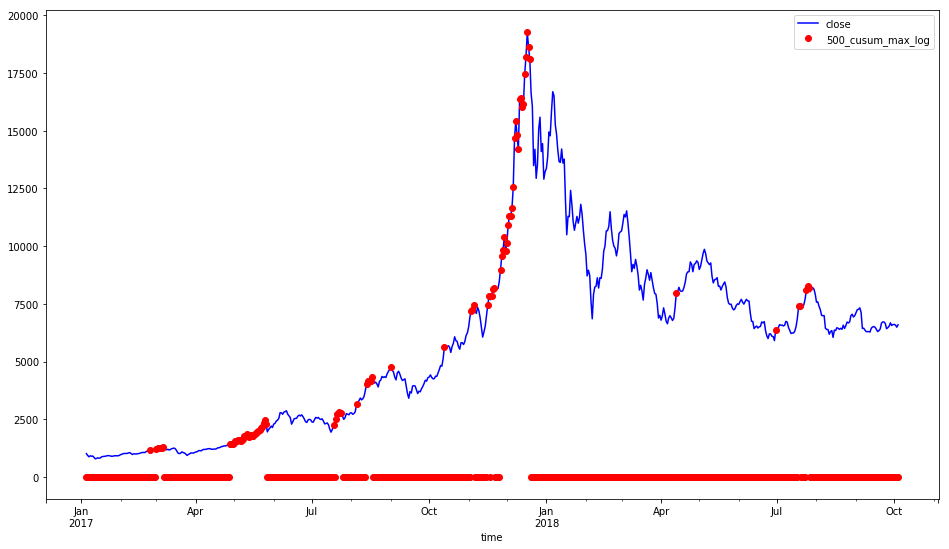

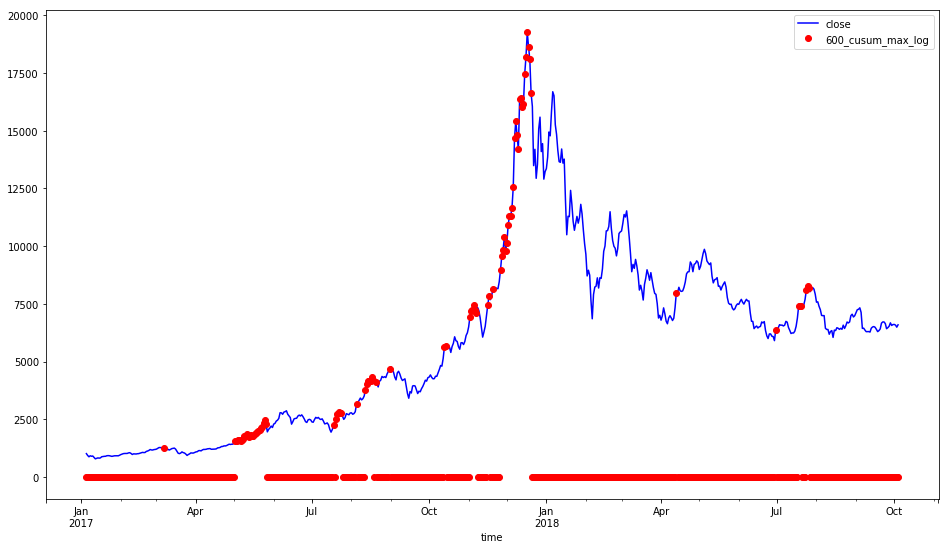

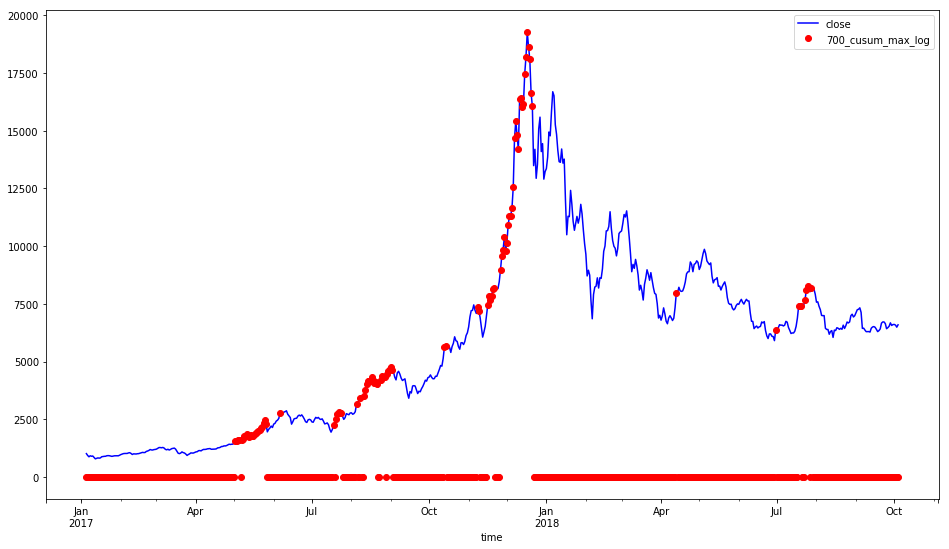

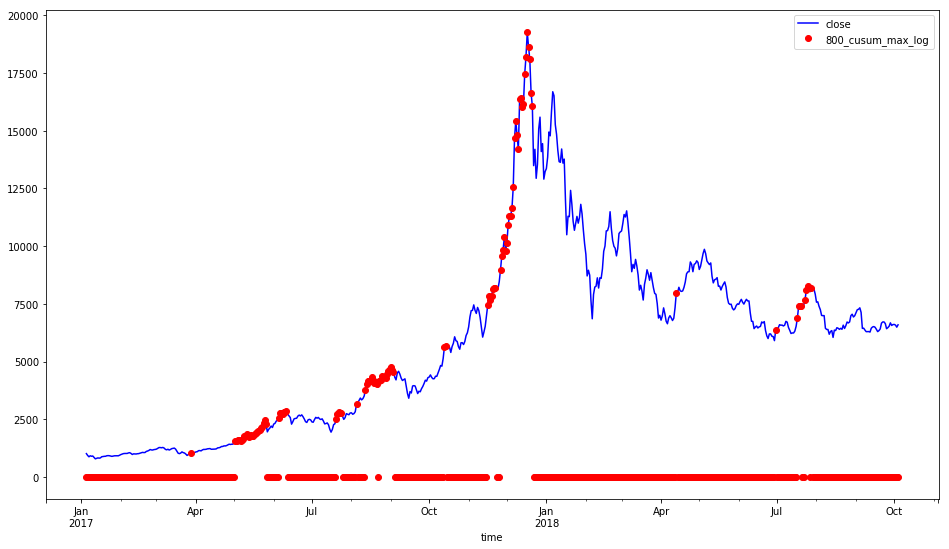

In [175]:
for feature in features:
    fig, ax = plt.subplots(figsize=(16,9))
    cusum = '{0}_cusum_max_log'.format(feature)
    cusum_test = '{0}_cusum_test'.format(feature)
    enriched_cusum['close'].plot(ax=ax, style='b-', legend=True)
    enriched_cusum[cusum] = enriched_cusum['close'].where(enriched_cusum[cusum_test] == 1.0, other=0.0)
    enriched_cusum[cusum].plot(ax=ax, style='ro', secondary_y=False, legend=True)